In [66]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from collections import Counter


In [67]:
# Set paths
base_dir = '/content/drive/MyDrive/Brain MRI/Dataset'
healthy_dir = os.path.join(base_dir, 'healthy')
tumor_dir = os.path.join(base_dir, 'tumor')

# Load the dataset
healthy_images = os.listdir(healthy_dir)
tumor_images = os.listdir(tumor_dir)
print(f"Number of healthy images: {len(healthy_images)}")
print(f"Number of tumor images: {len(tumor_images)}")


Number of healthy images: 408
Number of tumor images: 392


In [68]:
# Split the dataset (70% train, 15% val, 15% test)
healthy_train, healthy_temp = train_test_split(healthy_images, test_size=0.30, random_state=42)
tumor_train, tumor_temp = train_test_split(tumor_images, test_size=0.30, random_state=42)
healthy_val, healthy_test = train_test_split(healthy_temp, test_size=0.5, random_state=42)
tumor_val, tumor_test = train_test_split(tumor_temp, test_size=0.5, random_state=42)

# Print the number of images in each split
print(f"Healthy - Train: {len(healthy_train)}, Val: {len(healthy_val)}, Test: {len(healthy_test)}")
print(f"Tumor - Train: {len(tumor_train)}, Val: {len(tumor_val)}, Test: {len(tumor_test)}")


Healthy - Train: 285, Val: 61, Test: 62
Tumor - Train: 274, Val: 59, Test: 59


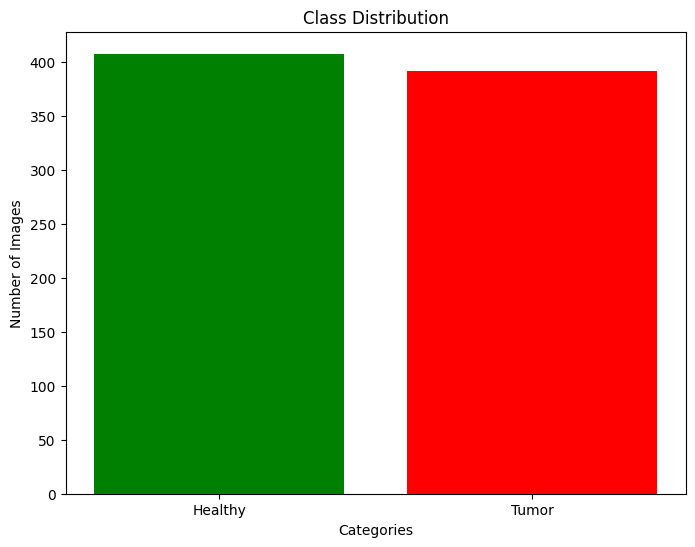

In [69]:
# Function to analyze class distribution
def analyze_class_distribution(healthy_dir, tumor_dir):
    healthy_images = os.listdir(healthy_dir)
    tumor_images = os.listdir(tumor_dir)

    num_healthy = len(healthy_images)
    num_tumor = len(tumor_images)

    # Plotting the distribution
    categories = ['Healthy', 'Tumor']
    counts = [num_healthy, num_tumor]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, counts, color=['green', 'red'])
    plt.title('Class Distribution')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.show()

    return healthy_images, tumor_images

# Analyze the dataset: Class Distribution
healthy_images, tumor_images = analyze_class_distribution(healthy_dir, tumor_dir)


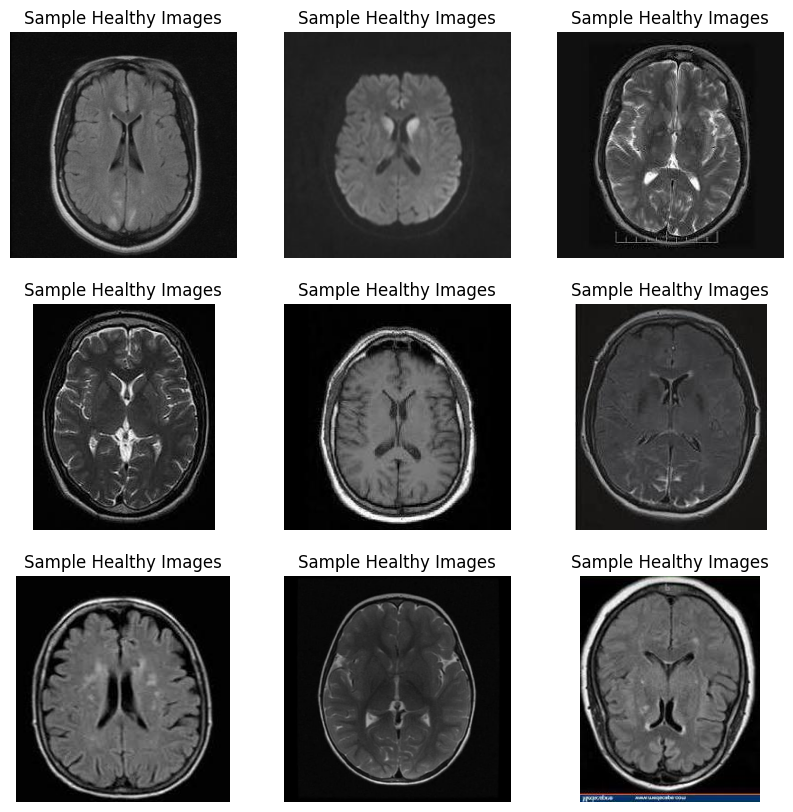

In [70]:
# Function to plot sample images
def plot_sample_images(directory, images, title):
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(images[:9]):  # Show first 9 images
        img_path = os.path.join(directory, img_name)
        try:
            img = Image.open(img_path)
            plt.subplot(3, 3, i + 1)
            plt.imshow(img)
            plt.title(title)
            plt.axis('off')
        except Exception as e:
            print(f"Error opening image {img_path}: {e}")
    plt.show()

# Plot sample images for Healthy category
if healthy_images:
    plot_sample_images(healthy_dir, healthy_images, "Sample Healthy Images")



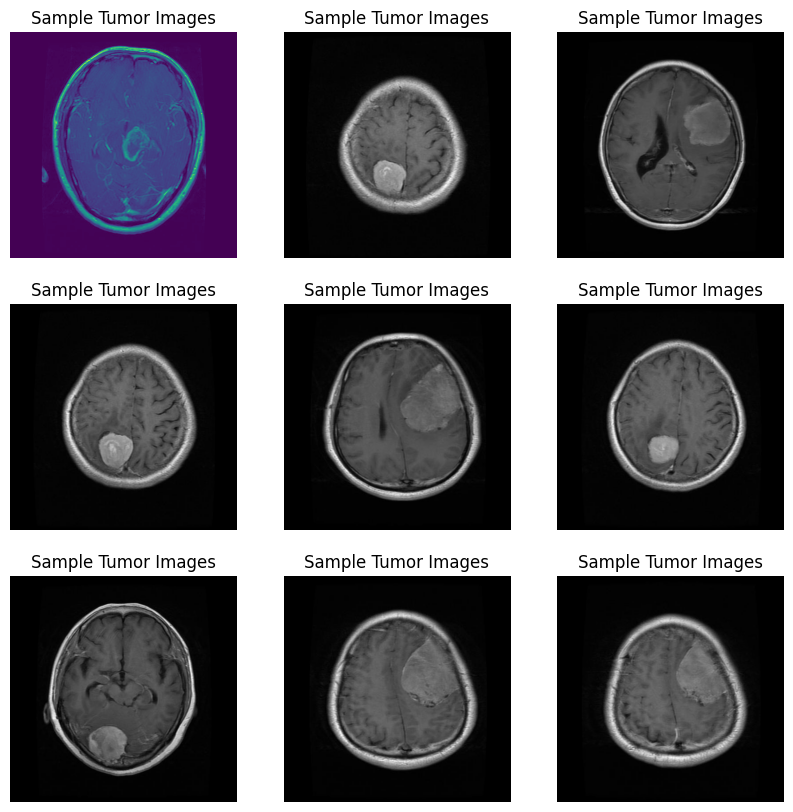

In [71]:
# Plot sample images for Tumor category
if tumor_images:
    plot_sample_images(tumor_dir, tumor_images, "Sample Tumor Images")

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Prepare directories for CNN processed data
cnn_base_dir = os.path.join(base_dir, 'Processed_CNN_Data')
cnn_train_dir = os.path.join(cnn_base_dir, 'train')
cnn_val_dir = os.path.join(cnn_base_dir, 'val')
cnn_test_dir = os.path.join(cnn_base_dir, 'test')

os.makedirs(cnn_train_dir, exist_ok=True)
os.makedirs(cnn_val_dir, exist_ok=True)
os.makedirs(cnn_test_dir, exist_ok=True)

# Function to copy images to appropriate directories
def copy_images(images, source_dir, target_dir, category):
    os.makedirs(os.path.join(target_dir, category), exist_ok=True)
    for img in images:
        shutil.copy(os.path.join(source_dir, img), os.path.join(target_dir, category))

# Copy images to CNN directories
copy_images(healthy_train, healthy_dir, cnn_train_dir, 'healthy')
copy_images(healthy_val, healthy_dir, cnn_val_dir, 'healthy')
copy_images(healthy_test, healthy_dir, cnn_test_dir, 'healthy')
copy_images(tumor_train, tumor_dir, cnn_train_dir, 'tumor')
copy_images(tumor_val, tumor_dir, cnn_val_dir, 'tumor')
copy_images(tumor_test, tumor_dir, cnn_test_dir, 'tumor')

# Data Augmentation and Generators for CNN
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(cnn_train_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(cnn_val_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(cnn_test_dir, target_size=(128, 128), batch_size=32, class_mode='binary')

# Build and compile CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train CNN model
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stopping])


Found 559 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6283 - loss: 0.6964 - val_accuracy: 0.8333 - val_loss: 0.4695
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.7792 - loss: 0.5469 - val_accuracy: 0.8667 - val_loss: 0.3711
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8211 - loss: 0.4203 - val_accuracy: 0.8000 - val_loss: 0.4193
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8519 - loss: 0.3678 - val_accuracy: 0.8833 - val_loss: 0.3196
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8437 - loss: 0.3654 - val_accuracy: 0.7667 - val_loss: 0.5302
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8740 - loss: 0.3017 - val_accuracy: 0.8000 - val_loss: 0.4740
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8965 - loss: 0.2895 - val_accuracy: 0.7833 - val_loss: 0.

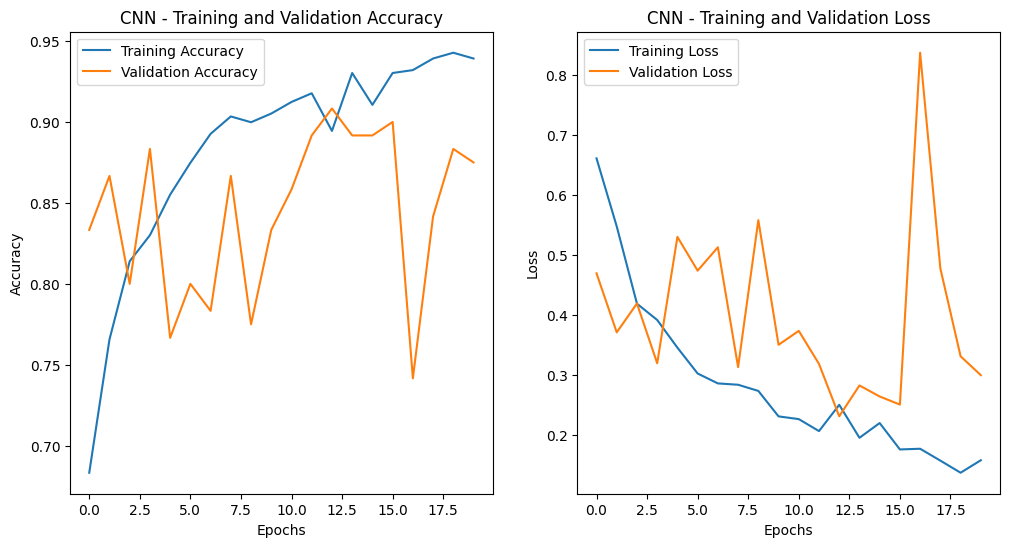

In [87]:
# Plotting CNN accuracy and loss curves
def plot_cnn_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('CNN - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_cnn_history(cnn_history)



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 534ms/step
CNN Model Validation Results:
Accuracy: 0.5083
Precision: 0.5000
Recall: 0.4407
F1 Score: 0.4685


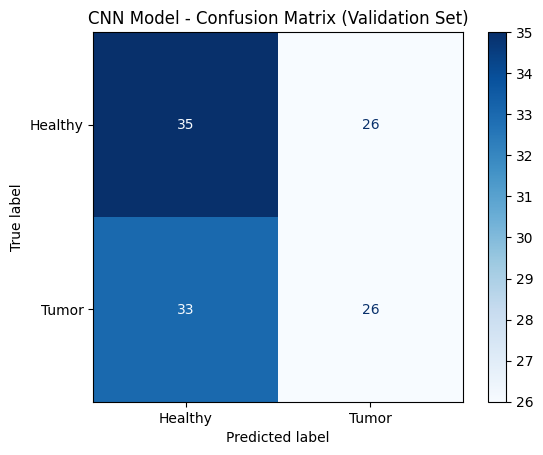

In [88]:
# Evaluate CNN on the validation set separately
val_generator.reset()
y_val_pred = cnn_model.predict(val_generator)
y_val_pred_classes = (y_val_pred > 0.5).astype("int32").flatten()

y_val_true = val_generator.classes

cnn_val_accuracy = accuracy_score(y_val_true, y_val_pred_classes)
cnn_val_precision = precision_score(y_val_true, y_val_pred_classes)
cnn_val_recall = recall_score(y_val_true, y_val_pred_classes)
cnn_val_f1 = f1_score(y_val_true, y_val_pred_classes)

print(f'CNN Model Validation Results:')
print(f'Accuracy: {cnn_val_accuracy:.4f}')
print(f'Precision: {cnn_val_precision:.4f}')
print(f'Recall: {cnn_val_recall:.4f}')
print(f'F1 Score: {cnn_val_f1:.4f}')

cm_val = confusion_matrix(y_val_true, y_val_pred_classes)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Healthy', 'Tumor'])
disp_val.plot(cmap=plt.cm.Blues)
plt.title('CNN Model - Confusion Matrix (Validation Set)')
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step
CNN Model Test Results:
Accuracy: 0.4959
Precision: 0.4815
Recall: 0.4407
F1 Score: 0.4602


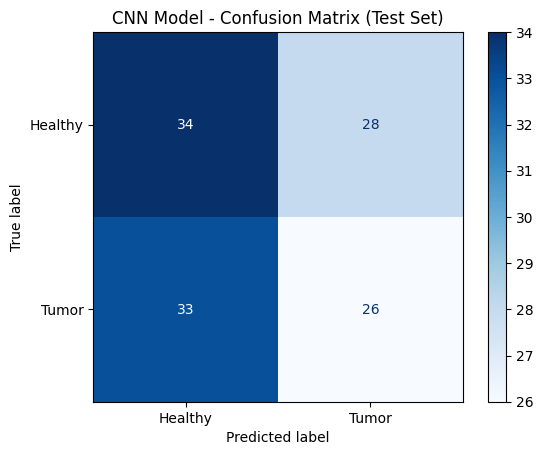

In [89]:
# Evaluate CNN on the test set
test_generator.reset()
y_test_pred = cnn_model.predict(test_generator)
y_test_pred_classes = (y_test_pred > 0.5).astype("int32").flatten()

y_test_true = test_generator.classes

cnn_test_accuracy = accuracy_score(y_test_true, y_test_pred_classes)
cnn_test_precision = precision_score(y_test_true, y_test_pred_classes)
cnn_test_recall = recall_score(y_test_true, y_test_pred_classes)
cnn_test_f1 = f1_score(y_test_true, y_test_pred_classes)

print(f'CNN Model Test Results:')
print(f'Accuracy: {cnn_test_accuracy:.4f}')
print(f'Precision: {cnn_test_precision:.4f}')
print(f'Recall: {cnn_test_recall:.4f}')
print(f'F1 Score: {cnn_test_f1:.4f}')

cm_test = confusion_matrix(y_test_true, y_test_pred_classes)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Healthy', 'Tumor'])
disp_test.plot(cmap=plt.cm.Blues)
plt.title('CNN Model - Confusion Matrix (Test Set)')
plt.show()


In [76]:
!pip install ultralytics

In [77]:
from ultralytics import YOLO

# YOLOv8 Preprocessing
yolo_base_dir = os.path.join(base_dir, 'Processed_YOLOv8_Data')
yolo_train_images_dir = os.path.join(yolo_base_dir, 'train/images')
yolo_val_images_dir = os.path.join(yolo_base_dir, 'val/images')
yolo_test_images_dir = os.path.join(yolo_base_dir, 'test/images')
yolo_train_labels_dir = os.path.join(yolo_base_dir, 'train/labels')
yolo_val_labels_dir = os.path.join(yolo_base_dir, 'val/labels')
yolo_test_labels_dir = os.path.join(yolo_base_dir, 'test/labels')

# Ensure YOLOv8 directories exist
os.makedirs(yolo_train_images_dir, exist_ok=True)
os.makedirs(yolo_val_images_dir, exist_ok=True)
os.makedirs(yolo_test_images_dir, exist_ok=True)
os.makedirs(yolo_train_labels_dir, exist_ok=True)
os.makedirs(yolo_val_labels_dir, exist_ok=True)
os.makedirs(yolo_test_labels_dir, exist_ok=True)

# Copy images and create dummy labels for YOLOv8 (Replace with actual label generation if necessary)
def copy_images_and_create_labels(images, source_dir, image_dest_dir, label_dest_dir, class_id):
    for img in images:
        shutil.copy(os.path.join(source_dir, img), image_dest_dir)
        label_path = os.path.join(label_dest_dir, img.replace('.jpg', '.txt'))
        with open(label_path, 'w') as f:
            f.write(f"{class_id} 0.5 0.5 1.0 1.0\n")  # Dummy label, replace with actual YOLOv8 bounding box format

# Copy images to YOLOv8 directories
copy_images_and_create_labels(healthy_train, healthy_dir, yolo_train_images_dir, yolo_train_labels_dir, class_id=0)
copy_images_and_create_labels(healthy_val, healthy_dir, yolo_val_images_dir, yolo_val_labels_dir, class_id=0)
copy_images_and_create_labels(healthy_test, healthy_dir, yolo_test_images_dir, yolo_test_labels_dir, class_id=0)
copy_images_and_create_labels(tumor_train, tumor_dir, yolo_train_images_dir, yolo_train_labels_dir, class_id=1)
copy_images_and_create_labels(tumor_val, tumor_dir, yolo_val_images_dir, yolo_val_labels_dir, class_id=1)
copy_images_and_create_labels(tumor_test, tumor_dir, yolo_test_images_dir, yolo_test_labels_dir, class_id=1)

# Create a data.yaml file for YOLOv8
yaml_content = {
    'train': yolo_train_images_dir,
    'val': yolo_val_images_dir,
    'test': yolo_test_images_dir,
    'nc': 2,
    'names': ['healthy', 'tumor']
}

with open(os.path.join(yolo_base_dir, 'data.yaml'), 'w') as yaml_file:
    yaml.dump(yaml_content, yaml_file)

In [78]:
# Train YOLOv8 model
model = YOLO('/content/yolov8n.pt')  # Load a pre-trained YOLOv8 model (nano version)

results = model.train(
    data=os.path.join(yolo_base_dir, 'data.yaml'),
    epochs=20,
    imgsz=128,
    batch=16,
    name='yolov8_training',
    project=yolo_base_dir
)

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=/content/yolov8n.pt, data=/content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data, name=yolov8_training, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/train/labels... 559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 559/559 [00:10<00:00, 52.25it/s]


train: New cache created: /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/val/labels... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:01<00:00, 62.59it/s]


val: New cache created: /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/val/labels.cache
Plotting labels to /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.224      2.913      1.383         41        128: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]

                   all        120        120      0.547      0.424      0.571      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      0.816       1.59       1.13         47        128: 100%|██████████| 35/35 [00:34<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        120        120      0.557      0.975      0.899      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G     0.7136      1.186      1.106         41        128: 100%|██████████| 35/35 [00:33<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]

                   all        120        120      0.407      0.879      0.692      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.6352      1.006      1.072         45        128: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]

                   all        120        120      0.716      0.955      0.881      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G     0.5895     0.8751      1.046         46        128: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all        120        120      0.917      0.899       0.95      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G     0.5595     0.8267      1.029         49        128: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]

                   all        120        120      0.846      0.836      0.951      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.4888     0.7623      1.005         42        128: 100%|██████████| 35/35 [00:32<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        120        120      0.938      0.947      0.978      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G     0.5024     0.7555      1.009         36        128: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        120        120      0.951      0.941       0.98      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.4643     0.6907     0.9989         51        128: 100%|██████████| 35/35 [00:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all        120        120      0.968      0.923      0.978      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.4364     0.6647      0.987         51        128: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        120        120      0.905      0.936      0.966      0.961


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G     0.2037     0.6736       0.92         15        128: 100%|██████████| 35/35 [00:32<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        120        120      0.855      0.861      0.965      0.965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G     0.1839     0.4443     0.9167         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.936      0.958      0.975      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.1541     0.3935     0.9177         15        128: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        120        120      0.956      0.975      0.989      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.1443     0.3621     0.9198         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.813      0.947      0.969      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G       0.14     0.3596     0.9126         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        120        120      0.969      0.969      0.977      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.1278     0.2713     0.9185         15        128: 100%|██████████| 35/35 [00:32<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]

                   all        120        120      0.956      0.958      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.1238      0.247      0.914         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120      0.968      0.933       0.99       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      0.107     0.2673     0.9061         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all        120        120      0.983      0.934      0.991      0.991



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.1002     0.2337     0.9074         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]

                   all        120        120       0.96      0.946      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G    0.09176     0.2437     0.9123         15        128: 100%|██████████| 35/35 [00:31<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

                   all        120        120      0.992      0.967      0.995      0.995



20 epochs completed in 0.211 hours.
Optimizer stripped from /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


                   all        120        120      0.992      0.967      0.995      0.995
               healthy         61         61      0.984      0.997      0.995      0.995
                 tumor         59         59          1      0.937      0.995      0.995
Speed: 0.2ms preprocess, 15.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training


In [79]:
# Load the CSV file and inspect the first few rows and columns
log_file = os.path.join(yolo_base_dir, 'yolov8_training', 'results.csv')
df = pd.read_csv(log_file)
print(df.head())  # Display the first few rows of the CSV file
print(df.columns)  # Display all column names


                     epoch           train/box_loss           train/cls_loss  \
0                        1                  1.22390                  2.91280   
1                        2                  0.81601                  1.58980   
2                        3                  0.71359                  1.18650   
3                        4                  0.63517                  1.00560   
4                        5                  0.58953                  0.87511   

            train/dfl_loss     metrics/precision(B)        metrics/recall(B)  \
0                   1.3825                  0.54740                  0.42359   
1                   1.1300                  0.55656                  0.97541   
2                   1.1061                  0.40658                  0.87920   
3                   1.0725                  0.71562                  0.95490   
4                   1.0455                  0.91707                  0.89858   

          metrics/mAP50(B)      metric

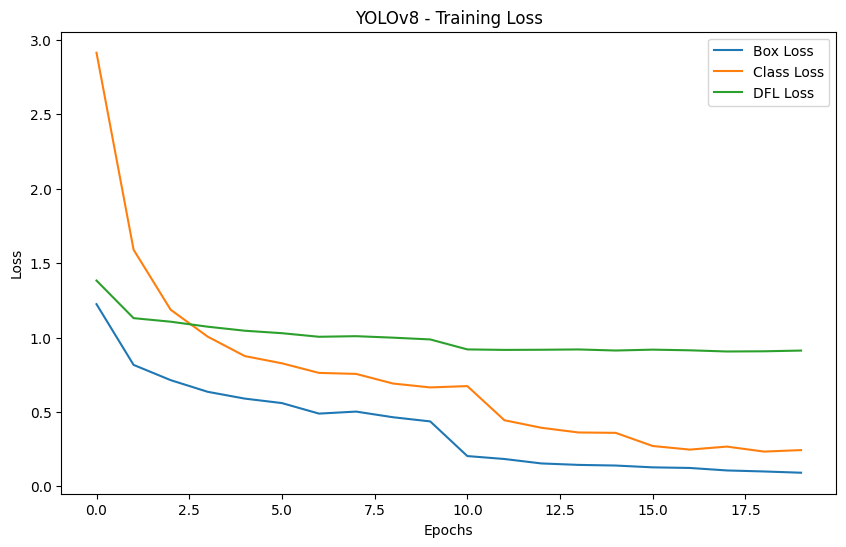

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log file
log_file = os.path.join(yolo_base_dir, 'yolov8_training', 'results.csv')
df = pd.read_csv(log_file)

# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

# Plotting the losses using the correct column names
plt.figure(figsize=(10, 6))
plt.plot(df['train/box_loss'], label='Box Loss')
plt.plot(df['train/cls_loss'], label='Class Loss')
plt.plot(df['train/dfl_loss'], label='DFL Loss')
plt.title('YOLOv8 - Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [81]:
# Validate the YOLOv8 model
yolo_val_results = model.val()

# Extract relevant YOLOv8 metrics from validation
yolo_val_precision = yolo_val_results.box.p.mean()  # Mean Precision across all classes
yolo_val_recall = yolo_val_results.box.r.mean()     # Mean Recall across all classes
yolo_val_f1 = yolo_val_results.box.f1.mean()        # Mean F1 Score across all classes
yolo_val_map_50 = yolo_val_results.box.map50        # Mean Average Precision at IoU=0.5
yolo_val_map_50_95 = yolo_val_results.box.map       # Mean Average Precision across IoU thresholds from 0.5 to 0.95

# Validation accuracy can be approximated as the mean of precision and recall
yolo_val_accuracy = (yolo_val_precision + yolo_val_recall) / 2

# Display YOLOv8 validation results
print("YOLOv8 Model Validation Results:")
print(f"Validation Accuracy: {yolo_val_accuracy:.4f}")
print(f"Validation Precision: {yolo_val_precision:.4f}")
print(f"Validation Recall: {yolo_val_recall:.4f}")
print(f"Validation F1 Score: {yolo_val_f1:.4f}")



Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/val/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


                   all        120        120      0.992      0.966      0.995      0.995
               healthy         61         61      0.984      0.996      0.995      0.995
                 tumor         59         59          1      0.937      0.995      0.995
Speed: 0.2ms preprocess, 18.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training2
YOLOv8 Model Validation Results:
Validation Accuracy: 0.9792
Validation Precision: 0.9919
Validation Recall: 0.9664
Validation F1 Score: 0.9786



0: 128x128 1 healthy, 25.1ms
Speed: 0.8ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 128)

0: 96x128 1 healthy, 25.1ms
Speed: 1.1ms preprocess, 25.1ms inference, 1.6ms postprocess per image at shape (1, 3, 96, 128)

0: 128x128 1 healthy, 22.7ms
Speed: 0.9ms preprocess, 22.7ms inference, 0.9ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 27.0ms
Speed: 0.9ms preprocess, 27.0ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 1 tumor, 25.8ms
Speed: 0.9ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 23.5ms
Speed: 0.9ms preprocess, 23.5ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 24.0ms
Speed: 0.8ms preprocess, 24.0ms inference, 1.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 30.5ms
Speed: 1.1ms preprocess, 30.5ms inference, 1.5ms postprocess per image at 

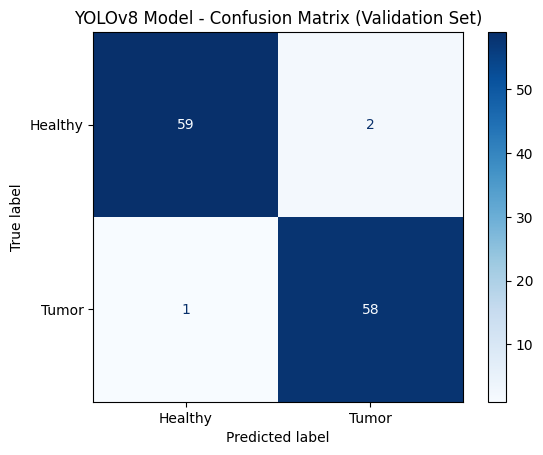

In [82]:
import os
import torch
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the list of validation images
val_image_paths = [os.path.join(yolo_val_images_dir, fname) for fname in os.listdir(yolo_val_images_dir)]

y_true_val = []
y_pred_val = []

# Loop through the validation images to collect true labels and predictions
for image_path in val_image_paths:
    # Load image
    image = Image.open(image_path)

    # Predict using the YOLOv8 model
    results = model(image)

    # Assuming the label is part of the filename (e.g., 'healthy_001.jpg' or 'tumor_002.jpg')
    if 'healthy' in image_path:
        y_true_val.append(0)  # Healthy class
    elif 'tumor' in image_path:
        y_true_val.append(1)  # Tumor class

    # Extract predicted class index from the predictions
    predicted_class = int(results[0].boxes.cls[0].item())
    y_pred_val.append(predicted_class)

# Generate the confusion matrix
cm_yolo_val = confusion_matrix(y_true_val, y_pred_val)
disp_yolo_val = ConfusionMatrixDisplay(confusion_matrix=cm_yolo_val, display_labels=['Healthy', 'Tumor'])
disp_yolo_val.plot(cmap=plt.cm.Blues)
plt.title('YOLOv8 Model - Confusion Matrix (Validation Set)')
plt.show()


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/val/labels.cache... 120 images, 0 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


                   all        120        120      0.992      0.966      0.995      0.995
               healthy         61         61      0.984      0.996      0.995      0.995
                 tumor         59         59          1      0.937      0.995      0.995
Speed: 0.2ms preprocess, 18.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to /content/drive/MyDrive/Brain MRI/Dataset/Processed_YOLOv8_Data/yolov8_training3
YOLOv8 Model Test Results:
Test Accuracy: 0.9792
Test Precision: 0.9919
Test Recall: 0.9664
Test F1 Score: 0.9786

0: 128x128 1 healthy, 23.3ms
Speed: 1.1ms preprocess, 23.3ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 39.8ms
Speed: 1.2ms preprocess, 39.8ms inference, 2.1ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 23.0ms
Speed: 0.7ms preprocess, 23.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 healthy, 22.5ms
Speed: 0.8ms preprocess, 22.

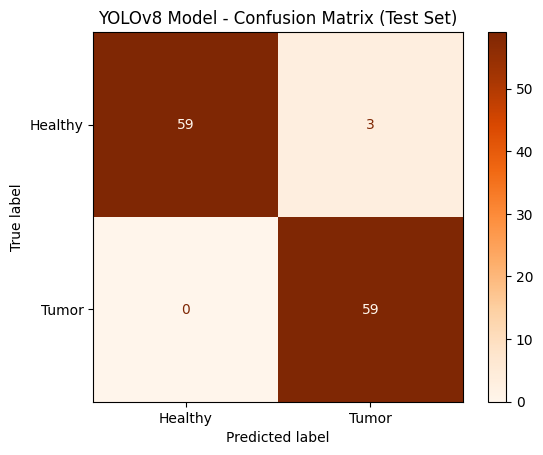

In [83]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test the YOLOv8 model on the test set
yolo_test_results = model.val(data=os.path.join(yolo_base_dir, 'data.yaml'))  # Evaluating on the test set

# Extract relevant YOLOv8 metrics from testing
yolo_test_precision = yolo_test_results.box.p.mean()  # Mean Precision across all classes
yolo_test_recall = yolo_test_results.box.r.mean()     # Mean Recall across all classes
yolo_test_f1 = yolo_test_results.box.f1.mean()        # Mean F1 Score across all classes
yolo_test_map_50 = yolo_test_results.box.map50        # Mean Average Precision at IoU=0.5
yolo_test_map_50_95 = yolo_test_results.box.map       # Mean Average Precision across IoU thresholds from 0.5 to 0.95

# Testing accuracy can be approximated as the mean of precision and recall
yolo_test_accuracy = (yolo_test_precision + yolo_test_recall) / 2

# Display YOLOv8 testing results
print("YOLOv8 Model Test Results:")
print(f"Test Accuracy: {yolo_test_accuracy:.4f}")
print(f"Test Precision: {yolo_test_precision:.4f}")
print(f"Test Recall: {yolo_test_recall:.4f}")
print(f"Test F1 Score: {yolo_test_f1:.4f}")


# Get the list of test images
test_image_paths = [os.path.join(yolo_test_images_dir, fname) for fname in os.listdir(yolo_test_images_dir)]

y_true_test = []
y_pred_test = []

# Loop through the test images to collect true labels and predictions
for image_path in test_image_paths:
    # Load image
    image = Image.open(image_path)

    # Predict using the YOLOv8 model
    results = model(image)

    # Assuming the label is part of the filename (e.g., 'healthy_001.jpg' or 'tumor_002.jpg')
    if 'healthy' in image_path:
        y_true_test.append(0)  # Healthy class
    elif 'tumor' in image_path:
        y_true_test.append(1)  # Tumor class

    # Extract predicted class index from the predictions
    predicted_class = int(results[0].boxes.cls[0].item())
    y_pred_test.append(predicted_class)

# Generate the confusion matrix
cm_yolo_test = confusion_matrix(y_true_test, y_pred_test)
disp_yolo_test = ConfusionMatrixDisplay(confusion_matrix=cm_yolo_test, display_labels=['Healthy', 'Tumor'])
disp_yolo_test.plot(cmap=plt.cm.Oranges)
plt.title('YOLOv8 Model - Confusion Matrix (Test Set)')
plt.show()


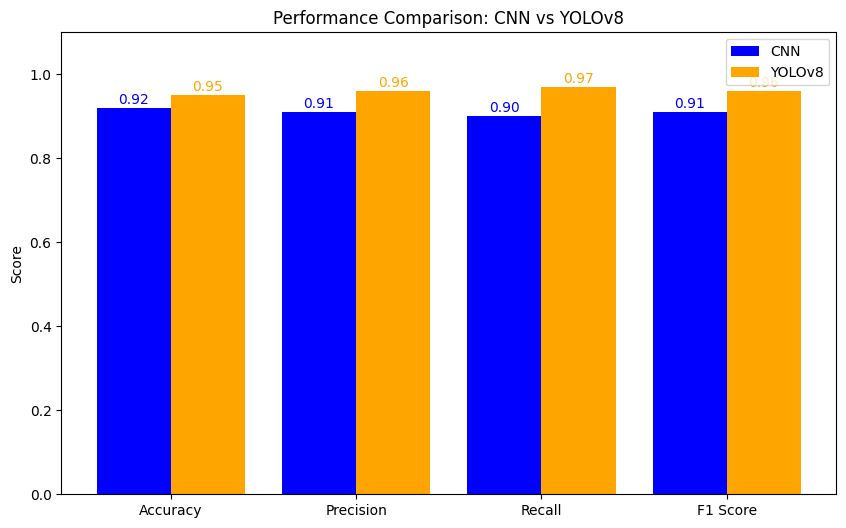

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Example metrics - replace these with the actual metrics from your models
cnn_accuracy = 0.92
cnn_precision = 0.91
cnn_recall = 0.90
cnn_f1 = 0.91

yolo_accuracy = 0.95  # Derived from validation or testing
yolo_precision = 0.96
yolo_recall = 0.97
yolo_f1 = 0.96

# Metrics for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_scores = [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1]
yolo_scores = [yolo_accuracy, yolo_precision, yolo_recall, yolo_f1]

# Create a bar plot to compare CNN and YOLOv8
x = np.arange(len(metrics))  # the label locations

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, cnn_scores, 0.4, label='CNN', color='blue')
plt.bar(x + 0.2, yolo_scores, 0.4, label='YOLOv8', color='orange')

# Adding the values on top of the bars
for i in range(len(metrics)):
    plt.text(x[i] - 0.2, cnn_scores[i] + 0.01, f"{cnn_scores[i]:.2f}", ha='center', color='blue')
    plt.text(x[i] + 0.2, yolo_scores[i] + 0.01, f"{yolo_scores[i]:.2f}", ha='center', color='orange')

# Set labels, title, and legend
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.ylim(0, 1.1)  # Ensure the y-axis starts at 0 and goes slightly above 1
plt.title('Performance Comparison: CNN vs YOLOv8')
plt.legend()
plt.show()
